Вивантаження всіх файлів із zip архіву. Фільтрування та перетворення даних для подальшого коректного аналізу

In [108]:
import zipfile
import pandas as pd

# Відкриваємо ZIP-архів
zip_file = zipfile.ZipFile('archive.zip', 'r')

# Створюємо порожній список для збереження вмісту CSV-файлів
csv_data = []

# Ітеруємося по всіх файлах в архіві і додаємо їх як датафрейми до списку
for file_name in zip_file.namelist():
    with zip_file.open(file_name) as file:
        df = pd.read_csv(file, header=None)
        csv_data.append(df)

# Закриваємо ZIP-архів
zip_file.close()

# Об'єднуємо всі датафрейми в один
combined_df = pd.concat(csv_data)

# Обробка даних
df = combined_df.dropna().drop_duplicates()
df.columns = df.iloc[0]
df = df.drop(index=0).reset_index(drop=True)

df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
2,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
3,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"
...,...,...,...,...,...,...
185681,259353,AAA Batteries (4-pack),3,2.99,09/17/19 20:56,"840 Highland St, Los Angeles, CA 90001"
185682,259354,iPhone,1,700,09/01/19 16:00,"216 Dogwood St, San Francisco, CA 94016"
185683,259355,iPhone,1,700,09/23/19 07:39,"220 12th St, San Francisco, CA 94016"
185684,259356,34in Ultrawide Monitor,1,379.99,09/19/19 17:30,"511 Forest St, San Francisco, CA 94016"


Визначення типів даних полів: 
- **Order ID**, **Quantity Ordered** - дискретні (*integer*)
- **Order Date** - неперервний (*datetime*)
- **Price Each** - неперервний (*float*)
- **Product**, **Purchase Address** - номінальні (*string*)

In [109]:
# привласнюємо правильні типи даних полям та фільтрую дані в розрізі одного року
df['Order ID'] = df['Order ID'].astype(int)
df['Product'] = df['Product'].astype(str)
df['Quantity Ordered'] = df['Quantity Ordered'].astype(int)
df['Price Each'] = df['Price Each'].astype(float)
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Purchase Address'] = df['Purchase Address'].astype(str)
df = df[df['Order Date'].dt.year == 2019]

df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001"
1,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215"
2,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
3,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001"
4,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001"
...,...,...,...,...,...,...
185681,259353,AAA Batteries (4-pack),3,2.99,2019-09-17 20:56:00,"840 Highland St, Los Angeles, CA 90001"
185682,259354,iPhone,1,700.00,2019-09-01 16:00:00,"216 Dogwood St, San Francisco, CA 94016"
185683,259355,iPhone,1,700.00,2019-09-23 07:39:00,"220 12th St, San Francisco, CA 94016"
185684,259356,34in Ultrawide Monitor,1,379.99,2019-09-19 17:30:00,"511 Forest St, San Francisco, CA 94016"


Додаю нові поля необхідні для подальшої агрегації та обробки даних

In [110]:
# створюю нові поля необхідні обробки даних
df_with_new_columns = df.copy()
df_with_new_columns[['Street', 'Сity', 'Index']] = df_with_new_columns['Purchase Address'].str.split(',', expand=True)
df_with_new_columns.loc[:, 'Short Date'] = df_with_new_columns['Order Date'].dt.date
# df_with_new_columns.loc[:, 'Month'] = df_with_new_columns['Order Date'].dt.month.astype(str) + ". " + df_with_new_columns['Order Date'].dt.month_name()
df_with_new_columns.loc[:, 'Month'] = df_with_new_columns['Order Date'].dt.month.astype('int')
df_with_new_columns.loc[:, 'Revenue'] = df_with_new_columns['Quantity Ordered'] * df_with_new_columns['Price Each'].round(2)

df_with_new_columns

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Street,Сity,Index,Short Date,Month,Revenue
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",917 1st St,Dallas,TX 75001,2019-04-19,4,23.90
1,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",682 Chestnut St,Boston,MA 02215,2019-04-07,4,99.99
2,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",669 Spruce St,Los Angeles,CA 90001,2019-04-12,4,600.00
3,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",669 Spruce St,Los Angeles,CA 90001,2019-04-12,4,11.99
4,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",333 8th St,Los Angeles,CA 90001,2019-04-30,4,11.99
...,...,...,...,...,...,...,...,...,...,...,...,...
185681,259353,AAA Batteries (4-pack),3,2.99,2019-09-17 20:56:00,"840 Highland St, Los Angeles, CA 90001",840 Highland St,Los Angeles,CA 90001,2019-09-17,9,8.97
185682,259354,iPhone,1,700.00,2019-09-01 16:00:00,"216 Dogwood St, San Francisco, CA 94016",216 Dogwood St,San Francisco,CA 94016,2019-09-01,9,700.00
185683,259355,iPhone,1,700.00,2019-09-23 07:39:00,"220 12th St, San Francisco, CA 94016",220 12th St,San Francisco,CA 94016,2019-09-23,9,700.00
185684,259356,34in Ultrawide Monitor,1,379.99,2019-09-19 17:30:00,"511 Forest St, San Francisco, CA 94016",511 Forest St,San Francisco,CA 94016,2019-09-19,9,379.99


Агрегую кількісні дані за всіма категоріями для подальшої вибіркової візуалізації

In [111]:
# кількість унікальних замовлень за вибраними категоріями
count_of_orders_by_city = df_with_new_columns.groupby('Сity')['Order ID'].nunique()
count_of_orders_by_month = df_with_new_columns.groupby('Month')['Order ID'].nunique()
count_of_orders_by_date = df_with_new_columns.groupby('Short Date')['Order ID'].nunique()
count_of_orders_by_product = df_with_new_columns.groupby('Product')['Order ID'].nunique()

# загальна кількість проданих товарів за вибраними категоріями
sum_of_items_by_city = df_with_new_columns.groupby('Сity')['Quantity Ordered'].sum()
sum_of_items_by_month = df_with_new_columns.groupby('Month')['Quantity Ordered'].sum()
sum_of_items_by_date = df_with_new_columns.groupby('Short Date')['Quantity Ordered'].sum()
sum_of_items_by_product = df_with_new_columns.groupby('Product')['Quantity Ordered'].sum()

# дохід за вибраними категоріями
revenue_by_city = df_with_new_columns.groupby('Сity')['Revenue'].sum()
revenue_by_month = df_with_new_columns.groupby('Month')['Revenue'].sum()
revenue_by_date = df_with_new_columns.groupby('Short Date')['Revenue'].sum()
revenue_by_product = df_with_new_columns.groupby('Product')['Revenue'].sum()

# кількість проданих товарів за ціною
sum_of_items_by_price = df_with_new_columns.groupby('Price Each')['Quantity Ordered'].sum()
# щомісячна кількість оплачених замовлень в день
count_of_orders_by_date_by_month = df_with_new_columns.groupby(['Short Date', 'Month'])['Order ID'].nunique()

**Pie plot** показує яку частку доходу принесло кожне місто за 2019 рік

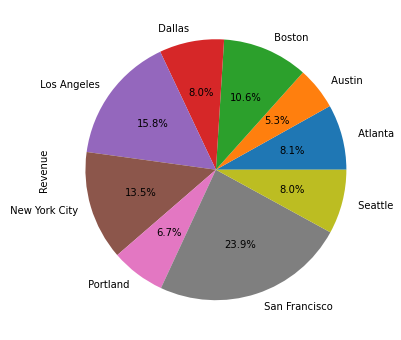

In [112]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
revenue_by_city.plot.pie(autopct='%1.1f%%')
plt.show()

**Bar chart** показує кількість проданих одиниць товару за спаданням

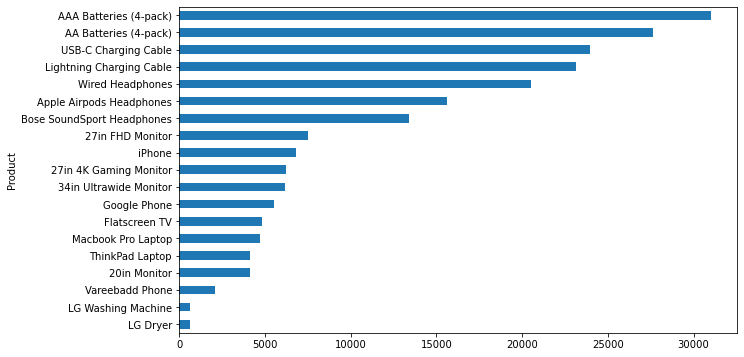

In [113]:
plt.figure(figsize=(10, 6))
sum_of_items_by_product.sort_values().plot.barh(rot=0)
plt.show()

**Line chart** показує щомісячно суму доходу за 2019 рік

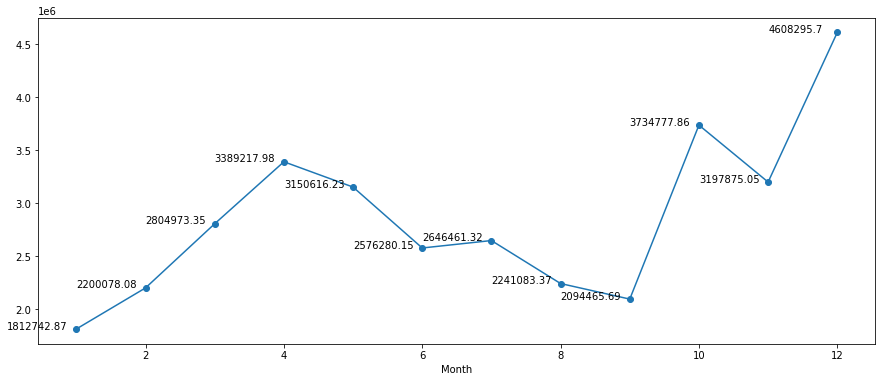

In [137]:
plt.figure(figsize=(15, 6))
revenue_by_month.plot(marker='o')

for i, value in enumerate(revenue_by_month):
    plt.text(i, value, str(value))

plt.show()

**Histogram** показує розподіл кількості замовлень, оформлених протягом дня. За графіком помітно, що такий розподіл відрізняється від нормального та зміщений вліво, що пояснюється великою кількістю товарів на суму менше 500 $

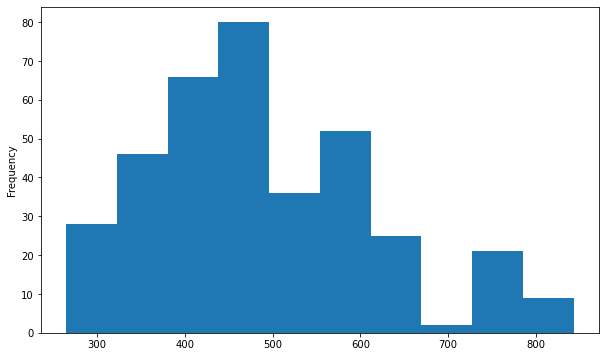

In [119]:
plt.figure(figsize=(10, 6))
count_of_orders_by_date.plot.hist()
plt.show()

**Scatter plot** показує залежність кількості проданих одиниць товару від їхньої суми. Тут очевидна закономірність - чим дешевший товар, тим більше продажів

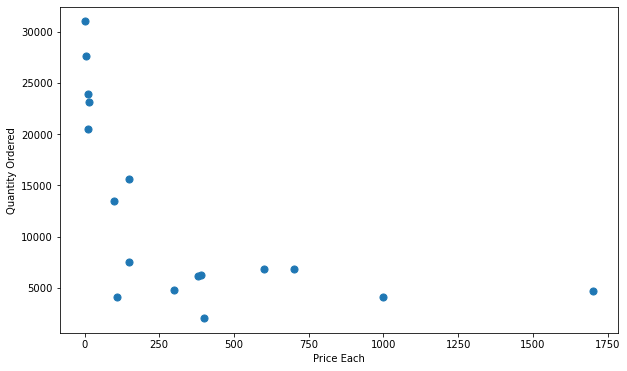

In [131]:
sum_of_items_by_price_df = sum_of_items_by_price.to_frame().reset_index()
sum_of_items_by_price_df.plot(x='Price Each', y='Quantity Ordered', kind='scatter', figsize=(10, 6), s = 50)
plt.show()

**Whisker plot** – описує статистичні дані помісячної кількості оплачених замовлень на день за допомогою квартилів. Дані відрізняються залежно від місяця, проте суттєвих викидів немає. Найбільш продаваним став грудень, що пояснюється новорічними святами, що наближаються, і з тієї ж причини гіршим місяцем став січень - закінчення всіх свят.

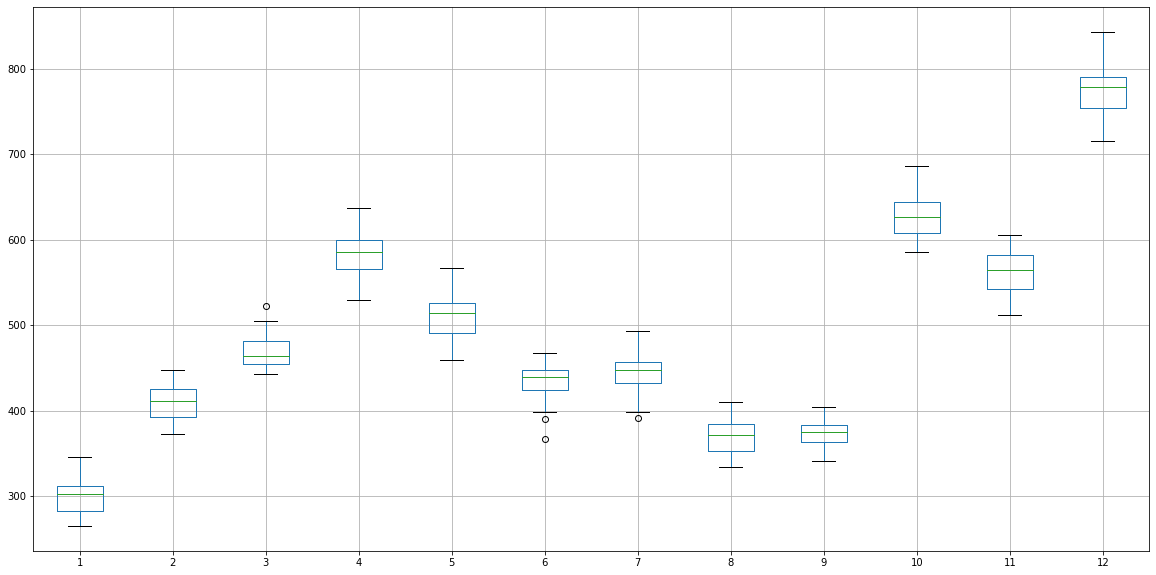

In [121]:
pivot_table = count_of_orders_by_date_by_month.to_frame().reset_index().pivot_table(index='Short Date', columns='Month', values='Order ID')

plt.figure(figsize=(20, 10))
boxplot = pivot_table.boxplot()

plt.show()

Зберігаю оброблений датафрейм у файл CSV для подальшої побудови дашборду

In [138]:
df_with_new_columns.to_csv('HW1.csv', index=False)